In [79]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [11]:
import torch
from datasets import load_from_disk

In [5]:
sys.path.append("/mnt/storage2/arafat_shovon/flow_matching_and_llm/notebooks")

In [6]:
from transformers import(
    Blip2ForConditionalGeneration,
    Blip2Processor
)

**Load the Model**

In [ ]:
model_name = "Salesforce/blip2-opt-2.7b"

processor = Blip2Processor.from_pretrained(model_name, 
                                        cache_dir="../data/cache")

model = Blip2ForConditionalGeneration.from_pretrained(model_name,
                                                    torch_dtype=torch.float16,
                                                    cache_dir="../data/cache",
                                                    device_map="auto")

**Load the Dataset**

In [12]:
data = load_from_disk("../data/flickr8k/train")

**GradCam Class**

In [ ]:
class Blip2GradCam():
    def __init__(self, model:Blip2ForConditionalGeneration, processor:Blip2Processor):
        
        self.model = model
        self.processor = processor
        self.device = next(model.parameters()).device
        
        self.target_layer = model.vision_model.encoder.layers[-1]
        self.activations = None
        self.gradients = None
        
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_full_backward_hook(self.backward_hook)

        for params in self.model.language_model.parameters():
            params.requires_grad = False
            
        for params in self.model.qformer.parameters():
            params.requires_grad = False
        
        
    def forward_hook(self, module:torch.nn.Module, input, output):
        self.activations = output[0].detach()
    
    
    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
        
    
    def generate_cam(self, image, prompt:str=None):
        orig_size = image.size
        text = prompt if prompt else None
        inputs = self.processor(images=image, text=text, return_tensors="pt").to(self.device, dtype=torch.float16)
        
        for param in self.model.vision_model.parameters():
            param.requires_grad = True
        
        self.model.eval()
        with torch.enable_grad():
            generated_ids = self.model.generate(**inputs)
            output = self.model(pixel_values=inputs['pixel_values'],
                                input_ids=generated_ids,
                                labels=generated_ids
                            )
            
            loss = output.loss
            self.model.zero_grad()
            loss.backward()
            
            cam = self.compute_cam()
            cam_resized = cv2.resize(cam, orig_size)
            caption = self.processor.decode(generated_ids[0], skip_special_tokens=True)
        
        return cam_resized, caption
    
    
    def compute_cam(self):
        weights = torch.mean(self.gradients, dim=-1, keepdim=True)
        cam = torch.sum(weights * self.activations, dim=-1)
        cam = cam[0]
        cam = cam[1:]
        num_patches = cam.shape[0]
        grid_size = int(np.sqrt(num_patches))
        cam = cam.reshape(grid_size, grid_size)
        cam = torch.nn.ReLU(cam)
        
        cam = (cam - cam.min())/cam.max()
        return cam.cpu().numpy()
        

In [74]:
grad_cam_model = Blip2GradCam(model=model, processor=processor)

In [ ]:
index = 203
image = data[index]['image']

inputs = processor(images=image, return_tensors="pt").to("cuda", dtype=torch.float16)
generated_ids = model.generate(**inputs, max_length=50)
print(processor.decode(generated_ids[0], skip_special_tokens=True))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7773438..2.0039062].


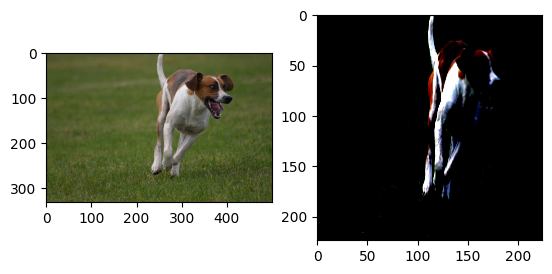

In [64]:
plt.subplot(1,2,1)
plt.imshow(image)

plt.subplot(1,2,2)
temp = inputs['pixel_values'][0].permute(1,2,0).detach().cpu()
plt.imshow(temp.to(torch.float32))

In [ ]:
cam_image = grad_cam_model.generate_cam(image)

In [78]:
image.size

(500, 332)